<a href="https://colab.research.google.com/github/MarcosVeniciu/Rede-Neural-Siamesa/blob/main/Rede_Siamesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
import zipfile as zf
import numpy as np
import shutil
import cv2
import os

size = 96

# Datasets

## Funções

In [2]:
def visualize(dataset):
  """Visualize a few triplets from the supplied batches."""
  for anchor, positive, negative in dataset.take(1):
    def show(ax, image):
        ax.imshow(image, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[0])
        show(axs[i, 1], positive[0])
        show(axs[i, 2], negative[0])

### Mnist

In [3]:
def descompactar_dataset(local):
  shutil.rmtree("Dataset", ignore_errors=True)
  local_destino = "Dataset"
  os.mkdir(local_destino) # Cria a pasta para salvar as imagens
  z = zf.ZipFile((local + ".zip"), 'r')
  z.extractall(local_destino)
  z.close()


def process_diretorio(local_img):
  img = cv2.imread(local_img, 0)
  img = np.array([img]) 
  img = img.reshape(96, 96, 1)
  img = img/255
  return img


def dataset_diretorio(quantidade_imagens = 20000): 
  nb_classes = 10
  local_base = "/content/Dataset/treino/"
  triplets=[np.zeros((quantidade_imagens, 96, 96, 1)) for i in range(3)]

  for i in range(quantidade_imagens):
    if i % 1000 == 0:
      print(str(i) + " imagens foram adicionadas.")

    anchor_class = np.random.randint(0, nb_classes) # Sorteia o indice de uma das classes de 0 a 9
    local_ancora = local_base + str(anchor_class)
    local_positiva = local_ancora 
    lista_imagens = os.listdir(local_ancora)
    nb_sample_available_for_class_AP = len(lista_imagens) # verifica a quantidade de imagens na classe de indice anchor_class
 
    # imagem ancora
    idx_A = np.random.randint(0, nb_sample_available_for_class_AP)
    local_ancora = local_ancora + "/" + lista_imagens[idx_A]

    # imagem positiva
    idx_P = np.random.randint(0, nb_sample_available_for_class_AP)
    local_positiva =  local_positiva + "/" +  lista_imagens[idx_P]

    # Imagem negativa
    negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes # seleciona uma outra classe para ser a negativa
    local_negativa = local_base + str(negative_class)
    lista_imagens = os.listdir(local_negativa)
    nb_sample_available_for_class_N = len(lista_imagens)
    idx_N = np.random.randint(0, nb_sample_available_for_class_N)
    local_negativa = local_negativa + "/" +  lista_imagens[idx_N]

    triplets[0][i,:,:,:] = process_diretorio(local_ancora)
    triplets[1][i,:,:,:] = process_diretorio(local_positiva)
    triplets[2][i,:,:,:] = process_diretorio(local_negativa)
 
  dataset = tf.data.Dataset.zip((
  tf.data.Dataset.from_tensor_slices(triplets[0]), # anchor_dataset
  tf.data.Dataset.from_tensor_slices(triplets[1]), # positive_dataset
  tf.data.Dataset.from_tensor_slices(triplets[2])))# negative_dataset
  return dataset 

## Gerar DataSet

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#descompactar_dataset("/content/drive/MyDrive/Codedepot/DataSets/mnist")

dataset = dataset_diretorio(quantidade_imagens = 10000)
dataset = dataset.shuffle(buffer_size=1024)
#visualize(dataset)

train_ds = dataset.take(round(len(dataset) * 0.8))
val_ds = dataset.skip(round(len(dataset) * 0.8))

print("Total de imagens: " + str(len(dataset)))
print("   Treinamento: " + str(len(train_ds)))
print("   Validação: " + str(len(val_ds)))


train_ds = train_ds.batch(32, drop_remainder=False)
val_ds = val_ds.batch(32, drop_remainder=False)
train_ds = train_ds.prefetch(8)
val_ds = val_ds.prefetch(8)

0 imagens foram adicionadas.
1000 imagens foram adicionadas.
2000 imagens foram adicionadas.
3000 imagens foram adicionadas.
4000 imagens foram adicionadas.
5000 imagens foram adicionadas.
6000 imagens foram adicionadas.
7000 imagens foram adicionadas.
8000 imagens foram adicionadas.
9000 imagens foram adicionadas.
Total de imagens: 10000
   Treinamento: 8000
   Validação: 2000


# Modelo

In [5]:
# Artigo: https://arxiv.org/pdf/1801.04381.pdf
# Codigo keras: https://github.com/keras-team/keras-applications/blob/06fbeb0f16e1304f239b2296578d1c50b15a983a/keras_applications/mobilenet_v2.py#L425
# Uma explicação sobre a arquitetura: https://machinethink.net/blog/mobilenet-v2/

def _make_divisible(v, divisor, min_value=None): # A mesma coisa do keras
  if min_value is None:
    min_value = divisor
  new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
  # Make sure that round down does not go down by more than 10%.
  if new_v < 0.9 * v:
    new_v += divisor
  return new_v


def bottleneck(inputs, expansion, stride, filters, alpha): # expansion = t, stride = s, filters = c
  x = inputs

  channel_axis = 1 if keras.backend.image_data_format() == 'channels_first' else -1
  in_channels = keras.backend.int_shape(inputs)[channel_axis]
  expanded_channel_axis = in_channels * expansion
  
  pointwise_conv_filters = int(filters * alpha)
  pointwise_filters = _make_divisible(pointwise_conv_filters, 8)

  # Expand: 1x1 conv2d , ReLU6 
  # Serve para multiplicar o numero de filtros da entrada por um fator de expansion
  x = layers.Conv2D(expanded_channel_axis, 1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x)

  # Depthwise: 3x3 dwise s=s, ReLU6 (s significa stride) 
  x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x)

  # Project: linear 1x1 conv2d, alpha = 1
  # serve para reverter o processo de expanção
  x = layers.Conv2D(pointwise_filters, 1, padding="same")(x)
  x = layers.BatchNormalization()(x)

  # A conexão residual é usada apenas quando o número de canais que entram no bloco é igual ao número que saem dele e o stride for igual a 1
  if ((in_channels == pointwise_filters) and (stride == 1)): 
   x = layers.Add()([inputs, x])

  return x


def model(input_shape, dropout = 0.5, alpha = 1, dropout_seed = 42):
  inputs = keras.Input(shape=input_shape)

  scale_layer = layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(inputs)

  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x) # Pode dar problema nesso troço de relu

  # bottleneck 1
  x = bottleneck(inputs= x , expansion= 1, stride= 1, filters= 16, alpha = alpha) # expansion = t, stride = s, filters = c

  # bottleneck 2 e 3
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 24, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 24, alpha = alpha)
  
  # bottleneck 4 
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 32, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 32, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 32, alpha = alpha)

  # bottleneck 7, 8, 9 e 10
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 64, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 64, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 64, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 64, alpha = alpha)

  # bottleneck 11, 12 e 13
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 96, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 96, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 96, alpha = alpha)
 
  # bottleneck 14, 15 e 16
  x = bottleneck(inputs= x , expansion= 6, stride= 2, filters= 160, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 160, alpha = alpha)
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 160, alpha = alpha)

  # bottleneck 17
  x = bottleneck(inputs= x , expansion= 6, stride= 1, filters= 320, alpha = alpha)


  x = layers.Conv2D(1280, 1, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU(6.)(x)

  x = layers.GlobalAveragePooling2D()(x)  
  outputs = layers.Dense(128)(x)
  
  return keras.Model(inputs, outputs, name="Embedding_MobileNetV2")

In [6]:
# https://keras.io/examples/vision/siamese_network/
# https://keras.io/examples/vision/siamese_contrastive/
# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
#tf.keras.backend.set_image_data_format('channels_first')

input_shape = (96,96, 1)


class DistanceLayer(keras.layers.Layer):
  """
  This layer is responsible for computing the distance between the anchor
  embedding and the positive embedding, and the anchor embedding and the
  negative embedding.
  """

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_distance, an_distance)



embedding_model = model(input_shape = input_shape)
embedding_model.summary()

def Siamese_Network():
  anchor_input = keras.layers.Input(name="anchor", shape= input_shape)
  positive_input = keras.layers.Input(name="positive", shape=input_shape)
  negative_input = keras.layers.Input(name="negative", shape=input_shape)

  distances = DistanceLayer()(
      embedding_model(anchor_input),
      embedding_model(positive_input),
      embedding_model(negative_input),
    )

  return keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances, name='Siamese_Network')

Model: "Embedding_MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   320         ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                   

In [7]:
class SiameseModel(keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.3):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

# Treinamento

In [8]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, monitor="val_loss", restore_best_weights=True),
  ]

In [9]:
siamese_model = SiameseModel(Siamese_Network())
siamese_model.compile(optimizer=keras.optimizers.Adam(0.0001), weighted_metrics=["loss"])

In [10]:
historico = siamese_model.fit(train_ds, epochs=20, callbacks=my_callbacks, validation_data = val_ds)
embedding_model.save("embedding_model.h5")

Epoch 1/20
250/250 [==============================] - 98s 159ms/step - loss: 0.3000 - val_loss: 0.3000
Epoch 2/20
250/250 [==============================] - 33s 131ms/step - loss: 0.3000 - val_loss: 0.3000
Epoch 3/20
  1/250 [..............................] - ETA: 48s - loss: 0.3000

KeyboardInterrupt: ignored

In [ ]:
def diferenca(historico):
  accuracy = historico.history['loss'] 
  val_accuracy = historico.history['val_loss']
  vetor_diferenca = []
  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca

  
def grafico(historico, nome): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,2,1)
  plt.title( nome + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.plot(historico.history['loss'], label='Train Loss ', color = 'blue')
  plt.plot(historico.history['val_loss'], label='Val Loss ', color = 'red')
  plt.legend()


  # Grafico 3: Diferença de Loss
  vetor_diferenca = diferenca(historico)

  plt.subplot(1,2,2)
  plt.title(nome + ": Variação do Loss")
  plt.xlabel("Epocas")
  plt.ylabel("Diferença")
  plt.grid()
  plt.plot(vetor_diferenca, color = 'red', label = 'Variação do Loss')
  plt.legend()

  nome_save = os.path.join("/content", nome + ".jpg")
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()


grafico(historico, "Rede Siamesa")

# Teste

## Funções

In [ ]:
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
def visualize(x_test_origin):
    """Visualize a few triplets from the supplied batches."""
    print("Total de imagens: {0}  Resolução: {1}x{2}".format(x_test_origin.shape[0], x_test_origin.shape[1], x_test_origin.shape[2]))
    def show(ax, image):
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 1], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 2], x_test_origin[np.random.randint(0, 1000)])

In [ ]:
nome = ["zero", "um", "dois", "tres", "quatro", "cinco", "seis", "sete", "oito", "nove"]

def array_to_imagem(image, novo_nome):
  novo_nome = "/content/imagens/" + novo_nome + ".jpg"
  cv2.imwrite(novo_nome, image)

def salvar_ancoras(x_test_origin, y_test_origin):
  os.mkdir("imagens")
  

  indice = 0
  i = 0
  while indice < 10:
    if y_test_origin[i] == indice:
      array_to_imagem(x_test_origin[i], nome[indice])
      indice += 1
    i+= 1

In [ ]:
def ler_imagem(local):
  return cv2.imread(local, 0)

In [ ]:
def prepare_database(model):
  database = {}
  local = "/content/imagens"
  for imagem in os.listdir(local):
    local_imagem = os.path.join(local, imagem)
    img = ler_imagem(local_imagem)
    identity = os.path.splitext(os.path.basename(local_imagem))[0]
    database[identity] = img_to_encoding(img, model)
  
  return database

In [ ]:
def recognise_class(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        #print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

In [ ]:
def img_to_encoding(img, model):
 # img = np.resize(image,(size,size))
  img = np.array([img]) 
  img = img.reshape(img.shape[0], 1, size, size)

  embedding = model.predict(img, verbose=0)
  
  return embedding

In [ ]:
def metricas(saida):
  certo = 0
  errado = 0
  incerto = 0
  
  for resposta in saida:
    if resposta[1] == nome[resposta[0]]:
      certo += 1
    else:
      if resposta[1] == "can't recognise.":
        incerto += 1
      else:
        if resposta[1] != nome[resposta[0]]:
          errado += 1
  print()
  print("Total de imagem: {0}    Certas: {1}   Erradas: {2}   Incertas: {3}".format(len(saida), certo, errado, incerto))

## Testes

Total de imagens: 10000  Resolução: 28x28


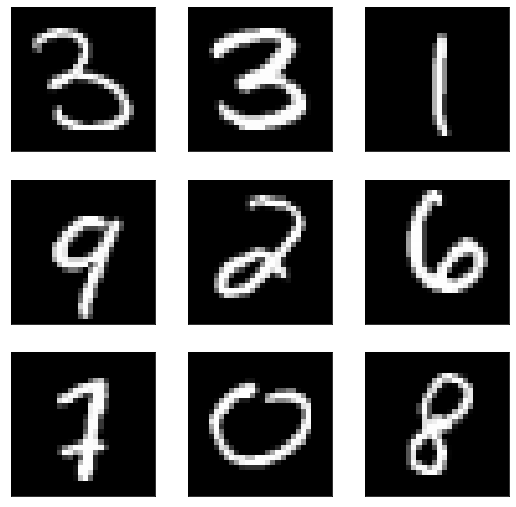

In [ ]:
# Permite visualizar algumas imagens do conjunto de teste
visualize(x_test_origin)

In [ ]:
# salvar uma imagem de cada classe para ser a ancora
salvar_ancoras(x_test_origin, y_test_origin)

Para classificar um imagem como pertencente a uma das classe, o processo é dividido em 4 fasses: \

1 - uma imagem representando cada classe é codificada. \

2 - a imagem que sera classifica é codificada. \

3 - verifica a distancia da imagem codificada na fasse 2 com cada uma das imagens codificadas na fasse 1. \

4 - a imagem sera classificada de acordo com a menor distancia encontrada na fasse 3.


In [ ]:
embedding_model = tf.keras.models.load_model("/content/embedding_model.h5")

In [ ]:
database = prepare_database(embedding_model)
saida = []

for i in range(15): # o maximo é 10000
  classe = recognise_class(x_test_origin[i], database, embedding_model)
  print("id {2}:: Classe Real: {0} >> Classe Prevista: {1}".format(y_test_origin[i], classe, i))
  saida.append([y_test_origin[i], classe])

metricas(saida) 

In [ ]:
imagens = cv2.imread("/content/temp.jpg", 0)

database = prepare_database(embedding_model)

classe = recognise_class(imagens, database, embedding_model)
print(classe)

In [ ]:
# verifica as imagem que deram errado
cv2.imwrite("teste.jpg",x_test_origin[7])